In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    auc,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score, 
    f1_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    log_loss
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize

import time

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

seed = 777

In [2]:
import pickle

(train_X_folds, train_y_folds, test_X_folds, test_y_folds, feature_names_folds, reverse_map_folds) = pickle.load(open('data/prepared_data.pkl', 'rb'))

In [3]:
train_X = train_X_folds[0]
train_y = train_y_folds[0]
test_X = test_X_folds[0]
test_y = test_y_folds[0]
feature_names = feature_names_folds[0]
reverse_map = reverse_map_folds[0]

In [4]:
class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    """
    Custom Logistic Regression with L1/L2 regularization, callback support, and class weights
    """
    
    def __init__(self, alpha=0.0, l1_ratio=0.0, max_iter=100, tol=1e-4, 
                 random_state=None, callback=None, class_weight=None):
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # 0 = L2, 1 = L1, 0.5 = Elastic Net
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.callback = callback
        self.class_weight = class_weight
        
        # Training history
        self.loss_history = []
        self.gradient_history = []
        self.iteration_history = []
        
    def _sigmoid(self, z):
        """Sigmoid function with numerical stability"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _log_likelihood(self, X, y, params):
        """Calculate weighted log-likelihood"""
        z = np.dot(X, params)
        probs = self._sigmoid(z)
        probs = np.clip(probs, 1e-15, 1-1e-15)
        
        # Calculate basic log-likelihood
        log_likelihood = y * np.log(probs) + (1 - y) * np.log(1 - probs)
        
        # Apply class weights if specified
        if self.class_weight is not None:
            if isinstance(self.class_weight, dict):
                # Dictionary format: {class_label: weight}
                weights = np.array([self.class_weight.get(label, 1.0) for label in y])
            elif isinstance(self.class_weight, str) and self.class_weight == 'balanced':
                # Balanced weights: n_samples / (n_classes * np.bincount(y))
                classes = np.unique(y)
                class_weights = compute_class_weight('balanced', classes=classes, y=y)
                weight_dict = dict(zip(classes, class_weights))
                weights = np.array([weight_dict[label] for label in y])
            else:
                # List/array format
                weights = np.array(self.class_weight)
            
            # Apply weights to log-likelihood
            log_likelihood = weights * log_likelihood
        
        return np.sum(log_likelihood)
    
    def _regularization_penalty(self, params):
        """Calculate regularization penalty"""
        if self.alpha == 0:
            return 0
        
        # L1 penalty
        l1_penalty = self.l1_ratio * np.sum(np.abs(params))
        
        # L2 penalty  
        l2_penalty = (1 - self.l1_ratio) * np.sum(params ** 2)
        
        return self.alpha * (l1_penalty + l2_penalty)
    
    def _objective(self, params, X, y):
        """Objective function to minimize"""
        # Negative log-likelihood
        nll = -self._log_likelihood(X, y, params)
        
        # Add regularization
        penalty = self._regularization_penalty(params)
        
        total_loss = nll + penalty
        
        # Store for history
        self.loss_history.append(total_loss)
        self.iteration_history.append(len(self.loss_history))
        
        # Call callback if provided
        if self.callback is not None:
            self.callback(params, total_loss, len(self.loss_history))
        
        return total_loss
    
    def _gradient(self, params, X, y):
        """Calculate gradient of the objective function with class weights"""
        z = np.dot(X, params)
        probs = self._sigmoid(z)
        
        # Calculate basic gradient of negative log-likelihood
        grad_nll = -np.dot(X.T, y - probs)
        
        # Apply class weights if specified
        if self.class_weight is not None:
            if isinstance(self.class_weight, dict):
                # Dictionary format: {class_label: weight}
                weights = np.array([self.class_weight.get(label, 1.0) for label in y])
            elif isinstance(self.class_weight, str) and self.class_weight == 'balanced':
                # Balanced weights: n_samples / (n_classes * np.bincount(y))
                classes = np.unique(y)
                class_weights = compute_class_weight('balanced', classes=classes, y=y)
                weight_dict = dict(zip(classes, class_weights))
                weights = np.array([weight_dict[label] for label in y])
            else:
                # List/array format
                weights = np.array(self.class_weight)
            
            # Apply weights to gradient
            # For each sample, multiply the gradient contribution by its weight
            weighted_residuals = weights * (y - probs)
            grad_nll = -np.dot(X.T, weighted_residuals)
        
        # Gradient of regularization
        grad_penalty = np.zeros_like(params)
        if self.alpha > 0:
            # L1 gradient (subgradient)
            if self.l1_ratio > 0:
                grad_penalty += self.alpha * self.l1_ratio * np.sign(params)
            
            # L2 gradient
            if self.l1_ratio < 1:
                grad_penalty += self.alpha * (1 - self.l1_ratio) * 2 * params
        
        total_grad = grad_nll + grad_penalty
        self.gradient_history.append(np.linalg.norm(total_grad))
        
        return total_grad
    
    def fit(self, X, y):
        """Fit the model"""
        X, y = check_X_y(X, y)
        
        # Add intercept column
        X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
        
        # Initialize parameters
        np.random.seed(self.random_state)
        n_features = X_with_intercept.shape[1]
        params = np.random.normal(0, 0.01, n_features)
        
        # Clear history
        self.loss_history = []
        self.gradient_history = []
        self.iteration_history = []
        
        # Optimize
        result = minimize(
            fun=self._objective,
            x0=params,
            args=(X_with_intercept, y),
            method='L-BFGS-B',
            jac=self._gradient,
            options={'maxiter': self.max_iter, 'ftol': self.tol}
        )
        
        # Store results
        self.coef_ = result.x[1:]  # Exclude intercept
        self.intercept_ = result.x[0]
        self.n_iter_ = result.nit
        
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X = check_array(X)
        z = np.dot(X, self.coef_) + self.intercept_
        probs = self._sigmoid(z)
        return np.column_stack([1 - probs, probs])
    
    def predict(self, X):
        """Predict class labels"""
        probs = self.predict_proba(X)
        return (probs[:, 1] > 0.5).astype(int)


In [5]:
class LossTracker:
    """
    Advanced loss tracker with callback support for custom GLM
    """
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        # Training history
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_nll_history = []
        self.test_nll_history = []
        self.penalty_history = []
        self.iteration_history = []
        self.gradient_norm_history = []
        
        # Current model state
        self.current_params = None
        self.current_alpha = None
        self.current_l1_ratio = None
        
    def _calculate_log_likelihood(self, X, y, params):
        """Calculate pure log-likelihood (no regularization)"""
        try:
            # Add intercept
            X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
            
            # Calculate probabilities
            z = np.dot(X_with_intercept, params)
            z = np.clip(z, -500, 500)
            probs = 1 / (1 + np.exp(-z))
            probs = np.clip(probs, 1e-15, 1-1e-15)
            
            # Calculate log-likelihood
            log_likelihood = np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
            return -log_likelihood  # Return negative log-likelihood
            
        except Exception as e:
            return np.inf
    
    def _calculate_regularization_penalty(self, params, alpha, l1_ratio):
        """Calculate regularization penalty"""
        if alpha == 0:
            return 0
        
        # L1 penalty
        l1_penalty = l1_ratio * np.sum(np.abs(params))
        
        # L2 penalty
        l2_penalty = (1 - l1_ratio) * np.sum(params ** 2)
        
        return alpha * (l1_penalty + l2_penalty)
    
    def create_callback(self, alpha, l1_ratio):
        """Create callback function for optimization"""
        self.current_alpha = alpha
        self.current_l1_ratio = l1_ratio
        
        def callback(params, loss, iteration):
            # Store current parameters
            self.current_params = params
            
            # Calculate pure log-likelihood (no regularization)
            train_nll = self._calculate_log_likelihood(self.X_train, self.y_train, params)
            test_nll = self._calculate_log_likelihood(self.X_test, self.y_test, params)
            
            # Calculate regularization penalty
            penalty = self._calculate_regularization_penalty(params, alpha, l1_ratio)
            
            # Store in history
            self.train_loss_history.append(loss)
            self.test_loss_history.append(test_nll)
            self.train_nll_history.append(train_nll)
            self.test_nll_history.append(test_nll)
            self.penalty_history.append(penalty)
            self.iteration_history.append(iteration)
            
            # Calculate gradient norm (approximate)
            if len(self.train_loss_history) > 1:
                grad_norm = abs(self.train_loss_history[-1] - self.train_loss_history[-2])
                self.gradient_norm_history.append(grad_norm)
            else:
                self.gradient_norm_history.append(0)
        
        return callback
    
    def get_summary(self):
        """Get training summary"""
        if not self.train_loss_history:
            return None
        
        return {
            'final_train_loss': self.train_loss_history[-1],
            'final_test_loss': self.test_loss_history[-1],
            'final_train_nll': self.train_nll_history[-1],
            'final_test_nll': self.test_nll_history[-1],
            'final_penalty': self.penalty_history[-1],
            'n_iterations': len(self.train_loss_history),
            'overfitting': self.train_loss_history[-1] - self.test_loss_history[-1],
            'convergence': self.gradient_norm_history[-1] if self.gradient_norm_history else 0
        }

In [ ]:
print("\n🔍 Testing L1 Regularization (L1 ratio = 1.0)...")
l1_alpha_values = [0.0, 0.1, 1.0, 10.0, 100.0]
l1_results = {}
l1_trackers = {}

for alpha in l1_alpha_values:
    print(f"Testing L1 α={alpha}...")
    
    # Create loss tracker
    tracker = LossTracker(train_X, train_y, test_X, test_y)
    callback = tracker.create_callback(alpha, l1_ratio=1.0)  # Pure L1
    
    # Create and fit model
    model = CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=1.0,  # Pure L1
        max_iter=50,
        tol=1e-6,
        class_weight="balanced",
        random_state=seed,
        callback=callback
    )
    
    start_time = time.time()
    try:
        model.fit(train_X, train_y)
        elapsed_time = time.time() - start_time
        
        # Get predictions and metrics
        train_pred = model.predict(train_X)
        test_pred = model.predict(test_X)
        train_pred_proba = model.predict_proba(train_X)[:, 1]
        test_pred_proba = model.predict_proba(test_X)[:, 1]
        
        train_accuracy = accuracy_score(train_y, train_pred)
        test_accuracy = accuracy_score(test_y, test_pred)
        train_auc = roc_auc_score(train_y, train_pred_proba)
        test_auc = roc_auc_score(test_y, test_pred_proba)
        
        summary = tracker.get_summary()
        
        l1_results[f"L1_α={alpha}"] = {
            'model': model,
            'tracker': tracker,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'n_iterations': model.n_iter_,
            'elapsed_time': elapsed_time,
            'summary': summary
        }
        l1_trackers[f"L1_α={alpha}"] = tracker
        
        print(f"✅ L1 α={alpha}: Train AUC={train_auc:.4f}, Test AUC={test_auc:.4f}, Iterations={model.n_iter_}")
        
    except Exception as e:
        print(f"❌ L1 α={alpha} failed: {str(e)[:100]}...")

print(f"\n✅ L1 testing completed: {len(l1_results)} successful configurations")

print("\n🔍 Testing L2 Regularization (L1 ratio = 0.0)...")
l2_alpha_values = [0.0, 0.1, 1.0, 10.0, 100.0]
l2_results = {}
l2_trackers = {}

for alpha in l2_alpha_values:
    print(f"Testing L2 α={alpha}...")
    
    # Create loss tracker
    tracker = LossTracker(train_X, train_y, test_X, test_y)
    callback = tracker.create_callback(alpha, l1_ratio=0.0)  # Pure L2
    
    # Create and fit model
    model = CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=0.0,  # Pure L2
        max_iter=50,
        tol=1e-6,
        class_weight="balanced",
        random_state=seed,
        callback=callback
    )
    
    start_time = time.time()
    try:
        model.fit(train_X, train_y)
        elapsed_time = time.time() - start_time
        
        # Get predictions and metrics
        train_pred = model.predict(train_X)
        test_pred = model.predict(test_X)
        train_pred_proba = model.predict_proba(train_X)[:, 1]
        test_pred_proba = model.predict_proba(test_X)[:, 1]
        
        train_accuracy = accuracy_score(train_y, train_pred)
        test_accuracy = accuracy_score(test_y, test_pred)
        train_auc = roc_auc_score(train_y, train_pred_proba)
        test_auc = roc_auc_score(test_y, test_pred_proba)
        
        summary = tracker.get_summary()
        
        l2_results[f"L2_α={alpha}"] = {
            'model': model,
            'tracker': tracker,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'n_iterations': model.n_iter_,
            'elapsed_time': elapsed_time,
            'summary': summary
        }
        l2_trackers[f"L2_α={alpha}"] = tracker
        
        print(f"✅ L2 α={alpha}: Train AUC={train_auc:.4f}, Test AUC={test_auc:.4f}, Iterations={model.n_iter_}")
        
    except Exception as e:
        print(f"❌ L2 α={alpha} failed: {str(e)[:100]}...")

print(f"\n✅ L2 testing completed: {len(l2_results)} successful configurations")



🔍 Testing L1 Regularization (L1 ratio = 1.0)...
Testing L1 α=0.0...
✅ L1 α=0.0: Train AUC=0.6922, Test AUC=0.6688, Iterations=50
Testing L1 α=0.1...
✅ L1 α=0.1: Train AUC=0.6923, Test AUC=0.6689, Iterations=50
Testing L1 α=1.0...
✅ L1 α=1.0: Train AUC=0.6922, Test AUC=0.6695, Iterations=50
Testing L1 α=10.0...
✅ L1 α=10.0: Train AUC=0.6894, Test AUC=0.6717, Iterations=50
Testing L1 α=100.0...
✅ L1 α=100.0: Train AUC=0.6717, Test AUC=0.6619, Iterations=50

🔍 Testing L2 Regularization (L1 ratio = 0.0)...
Testing L2 α=0.0...
✅ L2 α=0.0: Train AUC=0.6922, Test AUC=0.6688, Iterations=50
Testing L2 α=0.1...
✅ L2 α=0.1: Train AUC=0.6922, Test AUC=0.6688, Iterations=50
Testing L2 α=1.0...
✅ L2 α=1.0: Train AUC=0.6923, Test AUC=0.6694, Iterations=50
Testing L2 α=10.0...
✅ L2 α=10.0: Train AUC=0.6915, Test AUC=0.6706, Iterations=50
Testing L2 α=100.0...
✅ L2 α=100.0: Train AUC=0.6831, Test AUC=0.6669, Iterations=32

✅ L1 testing completed: 5 successful configurations
✅ L2 testing completed: 5 s

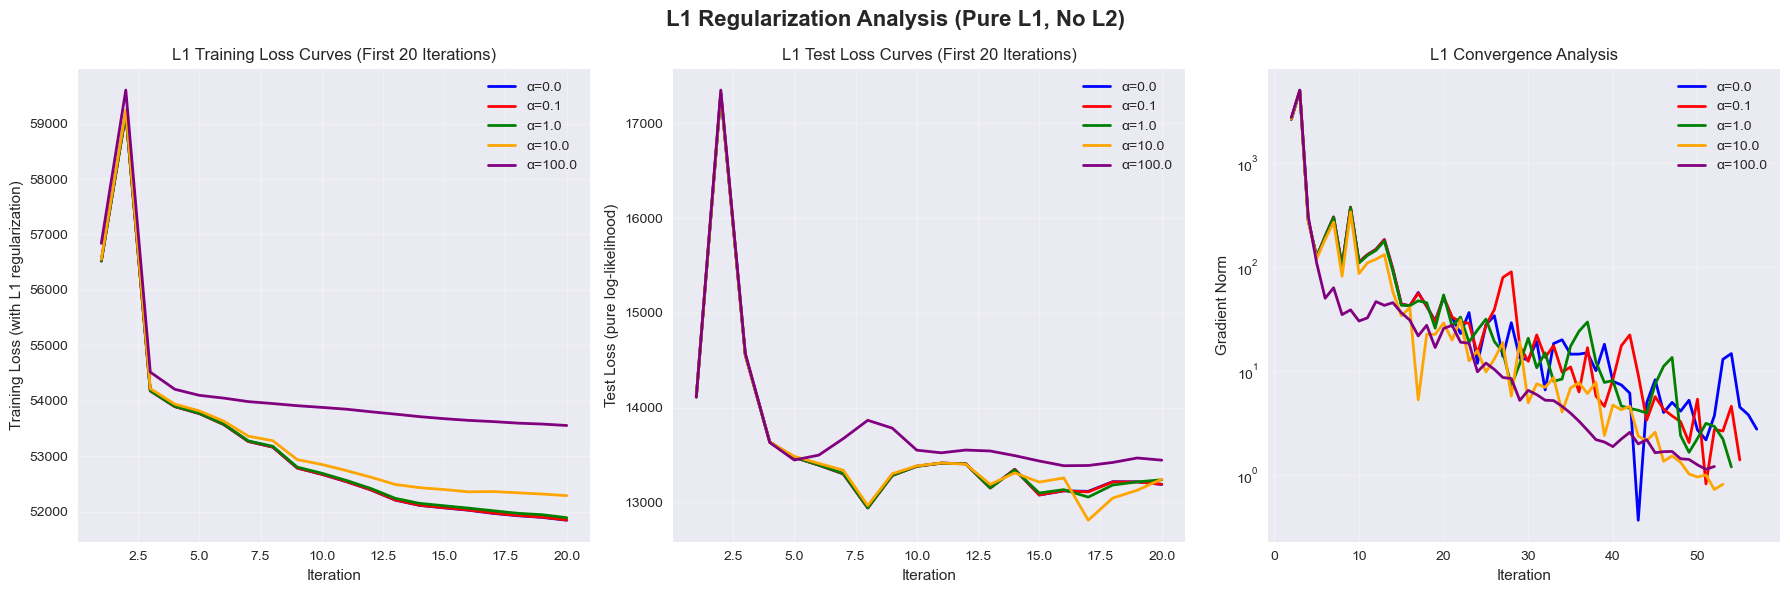


📊 L1 REGULARIZATION RESULTS:
L1 α=0.0: Test AUC=0.6688, Test Acc=0.6561, Iterations=50
L1 α=0.1: Test AUC=0.6689, Test Acc=0.6586, Iterations=50
L1 α=1.0: Test AUC=0.6695, Test Acc=0.6580, Iterations=50
L1 α=10.0: Test AUC=0.6717, Test Acc=0.6586, Iterations=50
L1 α=100.0: Test AUC=0.6619, Test Acc=0.6648, Iterations=50


In [7]:
# L1 REGULARIZATION CHARTS (3 CHARTS)
if l1_results:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('L1 Regularization Analysis (Pure L1, No L2)', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # 1. Training Loss Curves (first 20 iterations)
    ax1 = axes[0]
    for i, (key, result) in enumerate(l1_results.items()):
        tracker = result['tracker']
        if tracker.train_loss_history:
            # Limit to first 20 iterations
            iterations = tracker.iteration_history[:20]
            losses = tracker.train_loss_history[:20]
            ax1.plot(iterations, losses, 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Training Loss (with L1 regularization)')
    ax1.set_title('L1 Training Loss Curves (First 20 Iterations)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Test Loss Curves (first 20 iterations)
    ax2 = axes[1]
    for i, (key, result) in enumerate(l1_results.items()):
        tracker = result['tracker']
        if tracker.test_loss_history:
            # Limit to first 20 iterations
            iterations = tracker.iteration_history[:20]
            losses = tracker.test_loss_history[:20]
            ax2.plot(iterations, losses, 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Test Loss (pure log-likelihood)')
    ax2.set_title('L1 Test Loss Curves (First 20 Iterations)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Convergence Analysis
    ax3 = axes[2]
    for i, (key, result) in enumerate(l1_results.items()):
        tracker = result['tracker']
        if tracker.gradient_norm_history:
            ax3.plot(tracker.iteration_history[1:], tracker.gradient_norm_history[1:], 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Gradient Norm')
    ax3.set_title('L1 Convergence Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # L1 Results Summary
    print("\n📊 L1 REGULARIZATION RESULTS:")
    for key, result in l1_results.items():
        alpha = key.split("=")[1]
        print(f"L1 α={alpha}: Test AUC={result['test_auc']:.4f}, "
              f"Test Acc={result['test_accuracy']:.4f}, "
              f"Iterations={result['n_iterations']}")
    
else:
    print("❌ No L1 results to visualize")


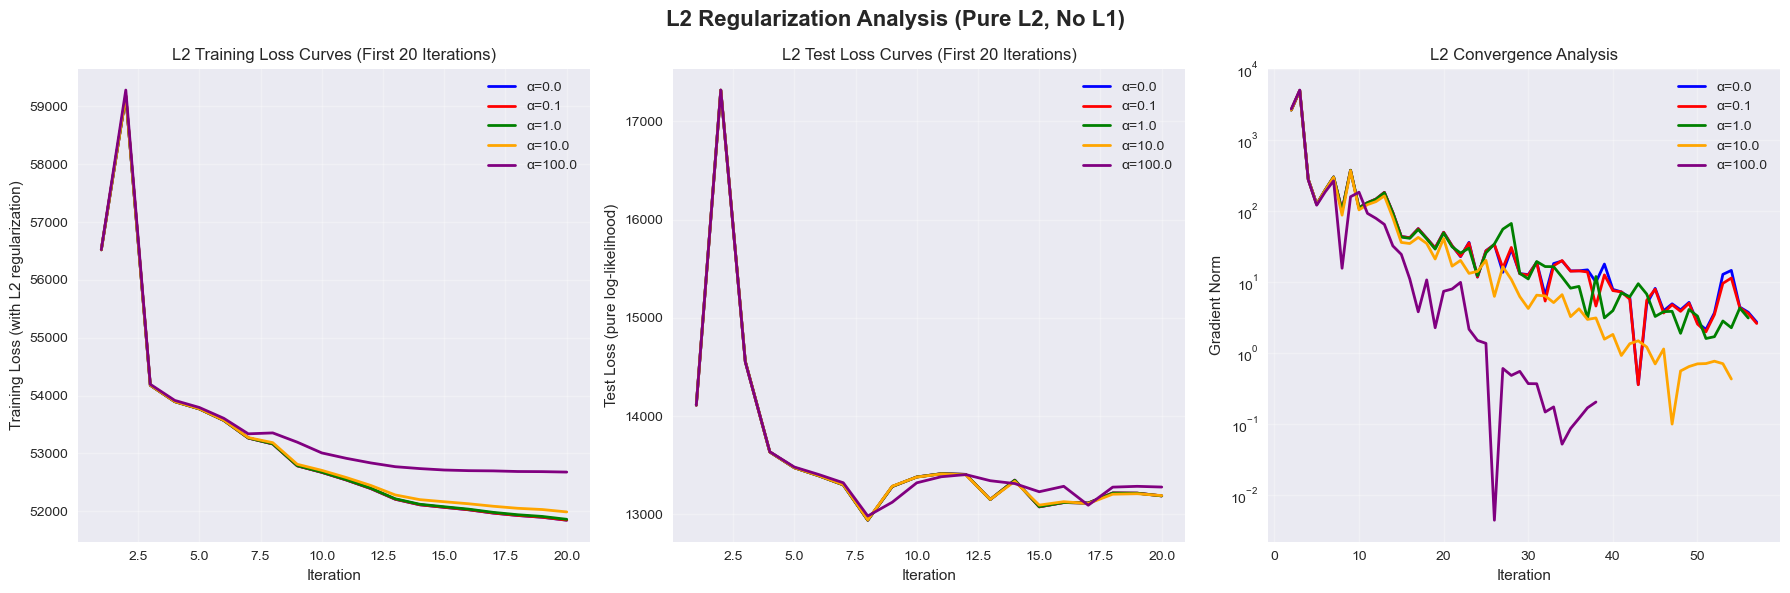


📊 L2 REGULARIZATION RESULTS:
L2 α=0.0: Test AUC=0.6688, Test Acc=0.6561, Iterations=50
L2 α=0.1: Test AUC=0.6688, Test Acc=0.6559, Iterations=50
L2 α=1.0: Test AUC=0.6694, Test Acc=0.6539, Iterations=50
L2 α=10.0: Test AUC=0.6706, Test Acc=0.6568, Iterations=50
L2 α=100.0: Test AUC=0.6669, Test Acc=0.6592, Iterations=32


In [8]:
# L2 REGULARIZATION CHARTS (3 CHARTS)
if l2_results:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('L2 Regularization Analysis (Pure L2, No L1)', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # 1. Training Loss Curves (first 20 iterations)
    ax1 = axes[0]
    for i, (key, result) in enumerate(l2_results.items()):
        tracker = result['tracker']
        if tracker.train_loss_history:
            # Limit to first 20 iterations
            iterations = tracker.iteration_history[:20]
            losses = tracker.train_loss_history[:20]
            ax1.plot(iterations, losses, 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Training Loss (with L2 regularization)')
    ax1.set_title('L2 Training Loss Curves (First 20 Iterations)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Test Loss Curves (first 20 iterations)
    ax2 = axes[1]
    for i, (key, result) in enumerate(l2_results.items()):
        tracker = result['tracker']
        if tracker.test_loss_history:
            # Limit to first 20 iterations
            iterations = tracker.iteration_history[:20]
            losses = tracker.test_loss_history[:20]
            ax2.plot(iterations, losses, 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Test Loss (pure log-likelihood)')
    ax2.set_title('L2 Test Loss Curves (First 20 Iterations)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Convergence Analysis
    ax3 = axes[2]
    for i, (key, result) in enumerate(l2_results.items()):
        tracker = result['tracker']
        if tracker.gradient_norm_history:
            ax3.plot(tracker.iteration_history[1:], tracker.gradient_norm_history[1:], 
                    color=colors[i % len(colors)], linewidth=2, label=f'α={key.split("=")[1]}')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Gradient Norm')
    ax3.set_title('L2 Convergence Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # L2 Results Summary
    print("\n📊 L2 REGULARIZATION RESULTS:")
    for key, result in l2_results.items():
        alpha = key.split("=")[1]
        print(f"L2 α={alpha}: Test AUC={result['test_auc']:.4f}, "
              f"Test Acc={result['test_accuracy']:.4f}, "
              f"Iterations={result['n_iterations']}")
    
else:
    print("❌ No L2 results to visualize")


In [9]:
# HEATMAP ANALYSIS: ALPHA vs L1 RATIO
print("=== HEATMAP ANALYSIS: ALPHA vs L1 RATIO ===")

# Test different alpha and L1 ratio combinations
alpha_values = [1, 2, 5]
l1_ratio_values = [0, 0.25, 0.5, 0.75, 1]

heatmap_results = {}
heatmap_auc = np.zeros((len(alpha_values), len(l1_ratio_values)))
heatmap_accuracy = np.zeros((len(alpha_values), len(l1_ratio_values)))
heatmap_iterations = np.zeros((len(alpha_values), len(l1_ratio_values)))

print(f"Testing {len(alpha_values)} alpha values × {len(l1_ratio_values)} L1 ratios = {len(alpha_values) * len(l1_ratio_values)} combinations...")

for i, alpha in enumerate(alpha_values):
    for j, l1_ratio in enumerate(l1_ratio_values):
        print(f"Testing α={alpha}, L1 ratio={l1_ratio}...")
        
        # Create loss tracker
        tracker = LossTracker(train_X, train_y, test_X, test_y)
        callback = tracker.create_callback(alpha, l1_ratio)
        
        # Create and fit model
        model = CustomLogisticRegression(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=50,
            tol=1e-6,
            class_weight="balanced",
            random_state=seed,
            callback=callback
        )
        
        start_time = time.time()
        try:
            model.fit(train_X, train_y)
            elapsed_time = time.time() - start_time
            
            # Get predictions and metrics
            train_pred = model.predict(train_X)
            test_pred = model.predict(test_X)
            train_pred_proba = model.predict_proba(train_X)[:, 1]
            test_pred_proba = model.predict_proba(test_X)[:, 1]
            
            train_accuracy = accuracy_score(train_y, train_pred)
            test_accuracy = accuracy_score(test_y, test_pred)
            train_auc = roc_auc_score(train_y, train_pred_proba)
            test_auc = roc_auc_score(test_y, test_pred_proba)
            
            # Store results
            key = f"α={alpha}_l1={l1_ratio}"
            heatmap_results[key] = {
                'model': model,
                'tracker': tracker,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_auc': train_auc,
                'test_auc': test_auc,
                'n_iterations': model.n_iter_,
                'elapsed_time': elapsed_time
            }
            
            # Store for heatmap
            heatmap_auc[i, j] = test_auc
            heatmap_accuracy[i, j] = test_accuracy
            heatmap_iterations[i, j] = model.n_iter_
            
            print(f"✅ α={alpha}, L1={l1_ratio}: Test AUC={test_auc:.4f}, Acc={test_accuracy:.4f}, Iter={model.n_iter_}")
            
        except Exception as e:
            print(f"❌ α={alpha}, L1={l1_ratio} failed: {str(e)[:100]}...")
            # Fill with NaN for failed cases
            heatmap_auc[i, j] = np.nan
            heatmap_accuracy[i, j] = np.nan
            heatmap_iterations[i, j] = np.nan

print(f"\n✅ Heatmap testing completed! {len(heatmap_results)} successful configurations.")


=== HEATMAP ANALYSIS: ALPHA vs L1 RATIO ===
Testing 3 alpha values × 5 L1 ratios = 15 combinations...
Testing α=1, L1 ratio=0...
✅ α=1, L1=0: Test AUC=0.6694, Acc=0.6539, Iter=50
Testing α=1, L1 ratio=0.25...
✅ α=1, L1=0.25: Test AUC=0.6695, Acc=0.6535, Iter=50
Testing α=1, L1 ratio=0.5...
✅ α=1, L1=0.5: Test AUC=0.6695, Acc=0.6542, Iter=50
Testing α=1, L1 ratio=0.75...
✅ α=1, L1=0.75: Test AUC=0.6691, Acc=0.6514, Iter=50
Testing α=1, L1 ratio=1...
✅ α=1, L1=1: Test AUC=0.6695, Acc=0.6580, Iter=50
Testing α=2, L1 ratio=0...
✅ α=2, L1=0: Test AUC=0.6695, Acc=0.6545, Iter=50
Testing α=2, L1 ratio=0.25...
✅ α=2, L1=0.25: Test AUC=0.6697, Acc=0.6515, Iter=50
Testing α=2, L1 ratio=0.5...
✅ α=2, L1=0.5: Test AUC=0.6700, Acc=0.6544, Iter=50
Testing α=2, L1 ratio=0.75...
✅ α=2, L1=0.75: Test AUC=0.6698, Acc=0.6537, Iter=50
Testing α=2, L1 ratio=1...
✅ α=2, L1=1: Test AUC=0.6700, Acc=0.6553, Iter=50
Testing α=5, L1 ratio=0...
✅ α=5, L1=0: Test AUC=0.6702, Acc=0.6550, Iter=50
Testing α=5, L1 rat

=== HEATMAP VISUALIZATIONS ===


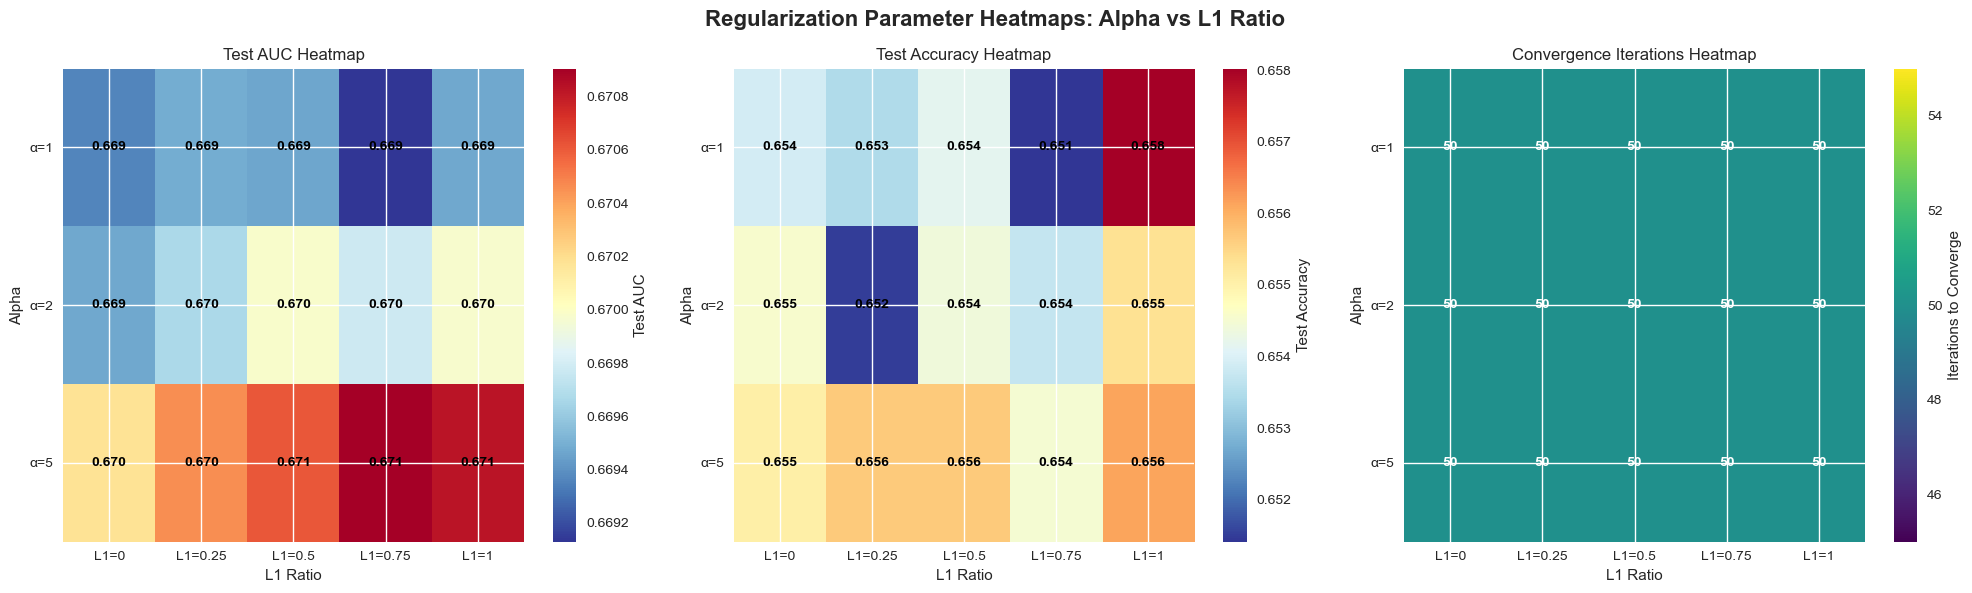


🏆 BEST CONFIGURATION:
   Alpha: 5
   L1 Ratio: 0.75
   Test AUC: 0.6709

📊 HEATMAP SUMMARY:
   Best Test AUC: 0.6709
   Worst Test AUC: 0.6691
   Mean Test AUC: 0.6699
   Std Test AUC: 0.0005


In [10]:
# HEATMAP VISUALIZATIONS
print("=== HEATMAP VISUALIZATIONS ===")

if len(heatmap_results) > 0:
    # Create heatmap visualizations
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Regularization Parameter Heatmaps: Alpha vs L1 Ratio', fontsize=16, fontweight='bold')
    
    # Create labels for axes
    alpha_labels = [f'α={a}' for a in alpha_values]
    l1_labels = [f'L1={r}' for r in l1_ratio_values]
    
    # 1. Test AUC Heatmap
    ax1 = axes[0]
    im1 = ax1.imshow(heatmap_auc, cmap='RdYlBu_r', aspect='auto')
    ax1.set_xticks(range(len(l1_ratio_values)))
    ax1.set_yticks(range(len(alpha_values)))
    ax1.set_xticklabels(l1_labels)
    ax1.set_yticklabels(alpha_labels)
    ax1.set_xlabel('L1 Ratio')
    ax1.set_ylabel('Alpha')
    ax1.set_title('Test AUC Heatmap')
    
    # Add text annotations
    for i in range(len(alpha_values)):
        for j in range(len(l1_ratio_values)):
            if not np.isnan(heatmap_auc[i, j]):
                text = ax1.text(j, i, f'{heatmap_auc[i, j]:.3f}', 
                               ha="center", va="center", color="black", fontweight='bold')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Test AUC')
    
    # 2. Test Accuracy Heatmap
    ax2 = axes[1]
    im2 = ax2.imshow(heatmap_accuracy, cmap='RdYlBu_r', aspect='auto')
    ax2.set_xticks(range(len(l1_ratio_values)))
    ax2.set_yticks(range(len(alpha_values)))
    ax2.set_xticklabels(l1_labels)
    ax2.set_yticklabels(alpha_labels)
    ax2.set_xlabel('L1 Ratio')
    ax2.set_ylabel('Alpha')
    ax2.set_title('Test Accuracy Heatmap')
    
    # Add text annotations
    for i in range(len(alpha_values)):
        for j in range(len(l1_ratio_values)):
            if not np.isnan(heatmap_accuracy[i, j]):
                text = ax2.text(j, i, f'{heatmap_accuracy[i, j]:.3f}', 
                               ha="center", va="center", color="black", fontweight='bold')
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Test Accuracy')
    
    # 3. Iterations Heatmap
    ax3 = axes[2]
    im3 = ax3.imshow(heatmap_iterations, cmap='viridis', aspect='auto')
    ax3.set_xticks(range(len(l1_ratio_values)))
    ax3.set_yticks(range(len(alpha_values)))
    ax3.set_xticklabels(l1_labels)
    ax3.set_yticklabels(alpha_labels)
    ax3.set_xlabel('L1 Ratio')
    ax3.set_ylabel('Alpha')
    ax3.set_title('Convergence Iterations Heatmap')
    
    # Add text annotations
    for i in range(len(alpha_values)):
        for j in range(len(l1_ratio_values)):
            if not np.isnan(heatmap_iterations[i, j]):
                text = ax3.text(j, i, f'{int(heatmap_iterations[i, j])}', 
                               ha="center", va="center", color="white", fontweight='bold')
    
    # Add colorbar
    cbar3 = plt.colorbar(im3, ax=ax3)
    cbar3.set_label('Iterations to Converge')
    
    plt.tight_layout()
    plt.show()
    
    # Find best configuration
    best_idx = np.unravel_index(np.nanargmax(heatmap_auc), heatmap_auc.shape)
    best_alpha = alpha_values[best_idx[0]]
    best_l1_ratio = l1_ratio_values[best_idx[1]]
    best_auc = heatmap_auc[best_idx]
    
    print(f"\n🏆 BEST CONFIGURATION:")
    print(f"   Alpha: {best_alpha}")
    print(f"   L1 Ratio: {best_l1_ratio}")
    print(f"   Test AUC: {best_auc:.4f}")
    
    # Summary statistics
    print(f"\n📊 HEATMAP SUMMARY:")
    print(f"   Best Test AUC: {np.nanmax(heatmap_auc):.4f}")
    print(f"   Worst Test AUC: {np.nanmin(heatmap_auc):.4f}")
    print(f"   Mean Test AUC: {np.nanmean(heatmap_auc):.4f}")
    print(f"   Std Test AUC: {np.nanstd(heatmap_auc):.4f}")

else:
    print("❌ No heatmap results to visualize")


=== BASELINE MODEL EVALUATION ===
Training model with α=5, L1 ratio=0.75 (Elastic Net)...
✅ Model trained successfully!
   Iterations: 97
   Time: 12.80s
📊 MODEL PERFORMANCE METRICS:
Train AUC: 0.6920
Test AUC: 0.6709
Train AUC-PR: 0.2217
Test AUC-PR: 0.2148

📈 DETAILED METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.6626     0.6567    
Precision            0.1860     0.1811    
Recall               0.6035     0.5725    
F1-Score             0.2843     0.2751    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 48439, FP: 23861
FN: 3581, TP: 5451
Test Confusion Matrix:
TN: 12089, FP: 6020
FN: 994, TP: 1331


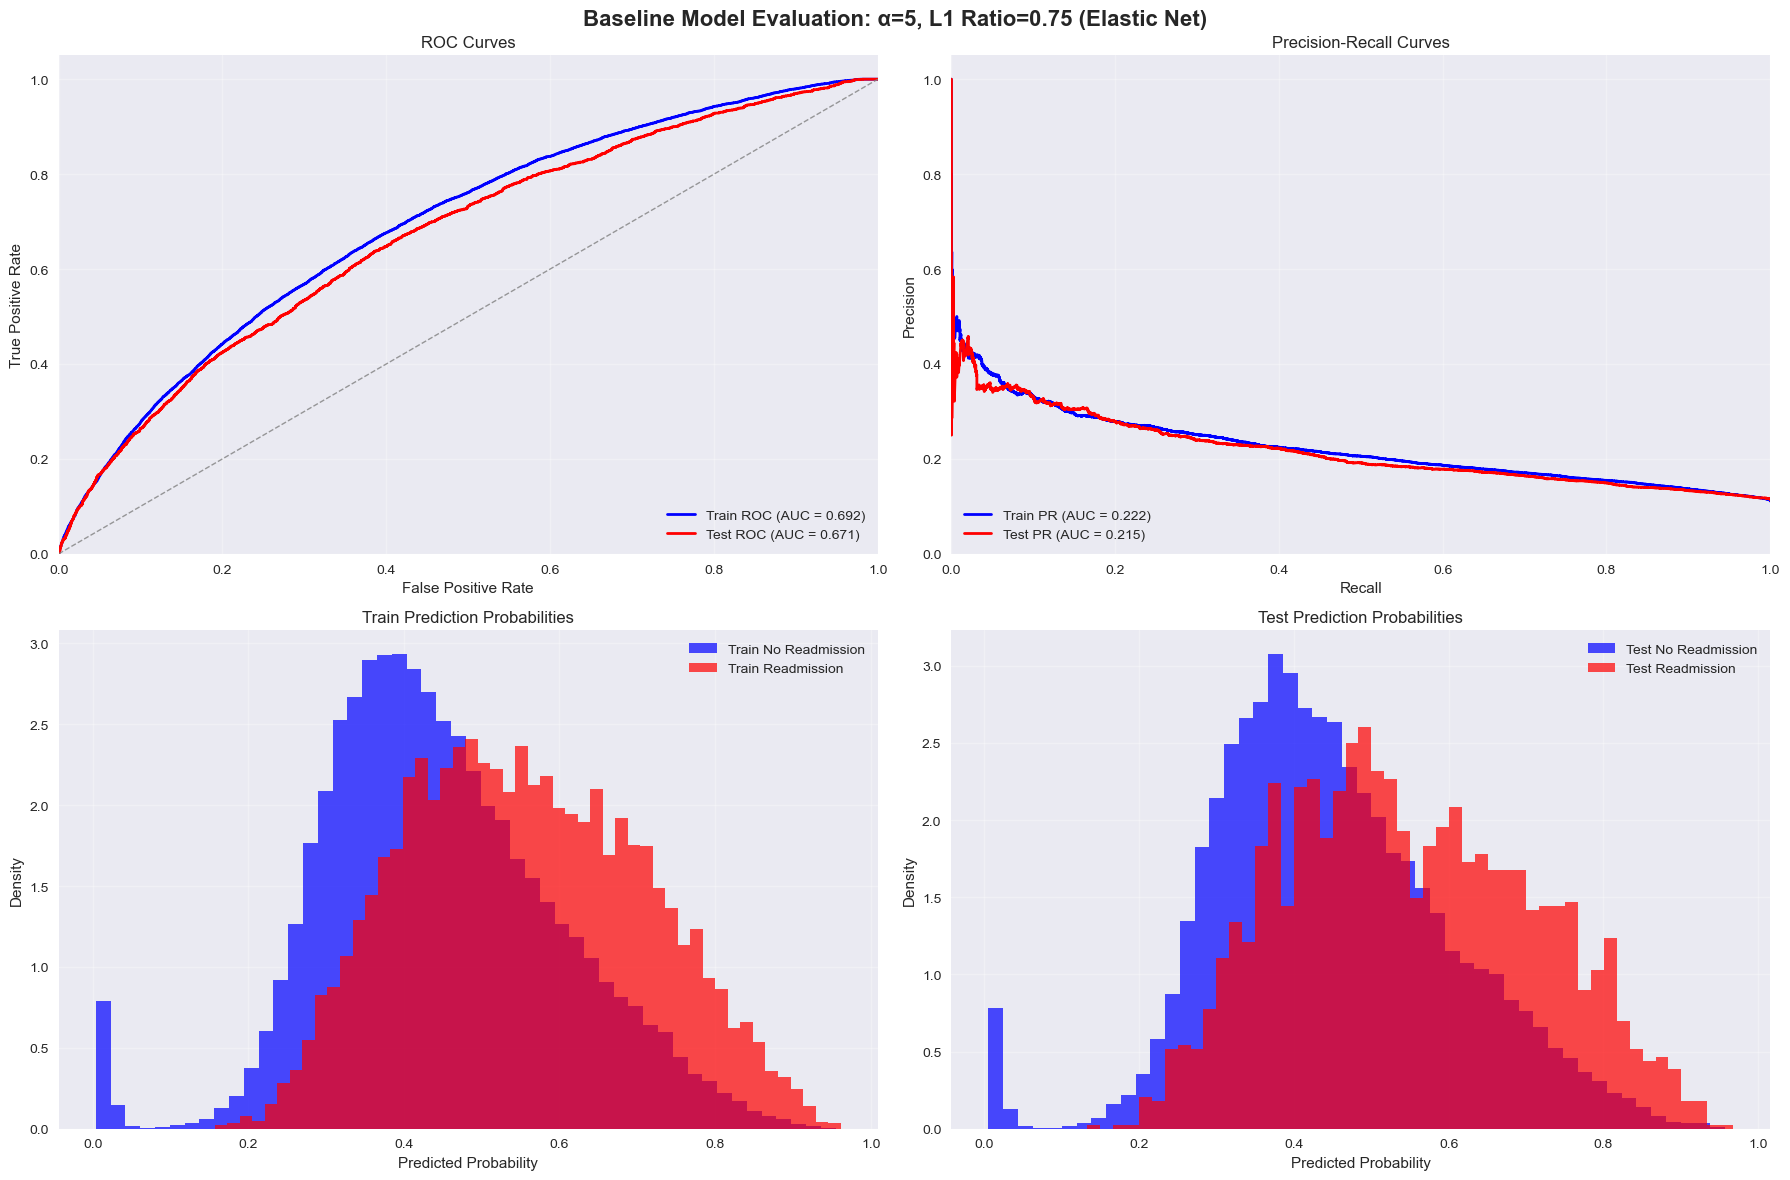


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.93      0.67      0.78     72300
   Readmission       0.19      0.60      0.28      9032

      accuracy                           0.66     81332
     macro avg       0.56      0.64      0.53     81332
  weighted avg       0.85      0.66      0.72     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.92      0.67      0.78     18109
   Readmission       0.18      0.57      0.28      2325

      accuracy                           0.66     20434
     macro avg       0.55      0.62      0.53     20434
  weighted avg       0.84      0.66      0.72     20434



In [11]:
print("=== BASELINE MODEL EVALUATION ===")

# Create model with specific parameters
alpha = 5
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio} (Elastic Net)...")

# Create and fit model
model = CustomLogisticRegression(
    alpha=alpha,
    l1_ratio=l1_ratio,
    max_iter=200,
    tol=1e-6,
    class_weight="balanced",
    random_state=seed,
    callback=callback
)

start_time = time.time()
model.fit(train_X, train_y)
elapsed_time = time.time() - start_time

print(f"✅ Model trained successfully!")
print(f"   Iterations: {model.n_iter_}")
print(f"   Time: {elapsed_time:.2f}s")

# Get predictions and metrics
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)
train_pred_proba = model.predict_proba(train_X)[:, 1]
test_pred_proba = model.predict_proba(test_X)[:, 1]

# Calculate ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_y, train_pred_proba)
test_fpr, test_tpr, test_thresholds = roc_curve(test_y, test_pred_proba)

# Calculate AUC scores
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

# Calculate precision-recall curves
train_precision, train_recall, train_pr_thresholds = precision_recall_curve(train_y, train_pred_proba)
test_precision, test_recall, test_pr_thresholds = precision_recall_curve(test_y, test_pred_proba)

# Calculate AUC-PR scores
train_auc_pr = auc(train_recall, train_precision)
test_auc_pr = auc(test_recall, test_precision)

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Train AUC-PR: {train_auc_pr:.4f}")
print(f"Test AUC-PR: {test_auc_pr:.4f}")

# Calculate additional metrics
train_accuracy = accuracy_score(train_y, train_pred)
test_accuracy = accuracy_score(test_y, test_pred)
train_precision_score = precision_score(train_y, train_pred)
test_precision_score = precision_score(test_y, test_pred)
train_recall_score = recall_score(train_y, train_pred)
test_recall_score = recall_score(test_y, test_pred)
train_f1 = f1_score(train_y, train_pred)
test_f1 = f1_score(test_y, test_pred)

print(f"\n📈 DETAILED METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f}")
print(f"{'Precision':<20} {train_precision_score:<10.4f} {test_precision_score:<10.4f}")
print(f"{'Recall':<20} {train_recall_score:<10.4f} {test_recall_score:<10.4f}")
print(f"{'F1-Score':<20} {train_f1:<10.4f} {test_f1:<10.4f}")

# Confusion matrices
train_cm = confusion_matrix(train_y, train_pred)
test_cm = confusion_matrix(test_y, test_pred)

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm[0,0]}, FP: {train_cm[0,1]}")
print(f"FN: {train_cm[1,0]}, TP: {train_cm[1,1]}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm[0,0]}, FP: {test_cm[0,1]}")
print(f"FN: {test_cm[1,0]}, TP: {test_cm[1,1]}")

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_auc:.3f})')
ax1.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Test ROC (AUC = {test_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall, train_precision, color='blue', lw=2, label=f'Train PR (AUC = {train_auc_pr:.3f})')
ax2.plot(test_recall, test_precision, color='red', lw=2, label=f'Test PR (AUC = {test_auc_pr:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred, target_names=['No Readmission', 'Readmission']))


=== WITHOUT CLASS BALANCING ===
Training model with α=5, L1 ratio=0.75 (Elastic Net)...
✅ Model trained successfully!
   Iterations: 68
   Time: 6.32s
📊 MODEL PERFORMANCE METRICS:
Train AUC: 0.6881
Test AUC: 0.6701
Train AUC-PR: 0.2230
Test AUC-PR: 0.2155

📈 DETAILED METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.8890     0.8860    
Precision            0.5091     0.4565    
Recall               0.0062     0.0090    
F1-Score             0.0123     0.0177    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 72246, FP: 54
FN: 8976, TP: 56
Test Confusion Matrix:
TN: 18084, FP: 25
FN: 2304, TP: 21


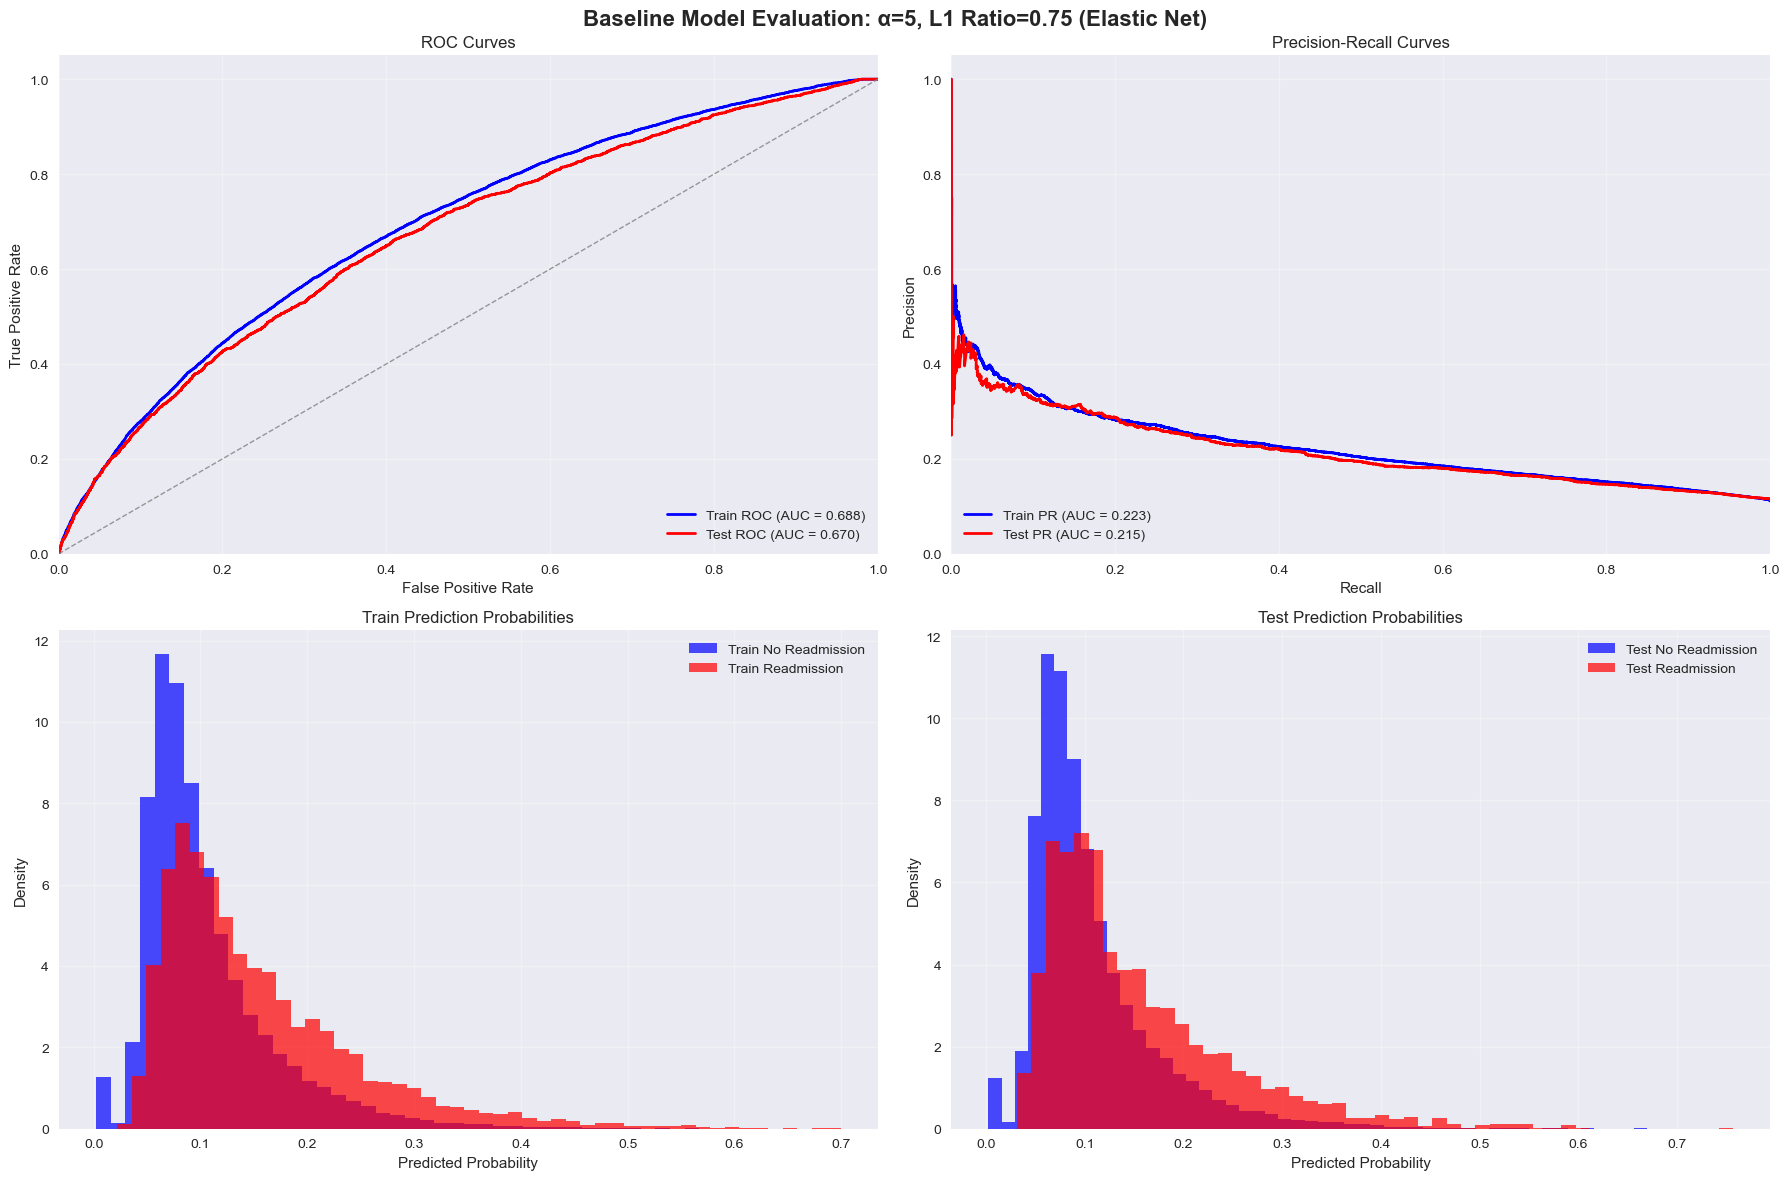


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     72300
   Readmission       0.51      0.01      0.01      9032

      accuracy                           0.89     81332
     macro avg       0.70      0.50      0.48     81332
  weighted avg       0.85      0.89      0.84     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     18109
   Readmission       0.46      0.01      0.02      2325

      accuracy                           0.89     20434
     macro avg       0.67      0.50      0.48     20434
  weighted avg       0.84      0.89      0.83     20434



In [12]:
print("=== WITHOUT CLASS BALANCING ===")

# Create model with specific parameters
alpha = 5
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio} (Elastic Net)...")

# Create and fit model
comparison_model = CustomLogisticRegression(
    alpha=alpha,
    l1_ratio=l1_ratio,
    max_iter=200,
    tol=1e-6,
    random_state=seed,
    callback=callback
)

start_time = time.time()
comparison_model.fit(train_X, train_y)
elapsed_time = time.time() - start_time

print(f"✅ Model trained successfully!")
print(f"   Iterations: {comparison_model.n_iter_}")
print(f"   Time: {elapsed_time:.2f}s")

# Get predictions and metrics
train_pred = comparison_model.predict(train_X)
test_pred = comparison_model.predict(test_X)
train_pred_proba = comparison_model.predict_proba(train_X)[:, 1]
test_pred_proba = comparison_model.predict_proba(test_X)[:, 1]

# Calculate ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_y, train_pred_proba)
test_fpr, test_tpr, test_thresholds = roc_curve(test_y, test_pred_proba)

# Calculate AUC scores
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

# Calculate precision-recall curves
train_precision, train_recall, train_pr_thresholds = precision_recall_curve(train_y, train_pred_proba)
test_precision, test_recall, test_pr_thresholds = precision_recall_curve(test_y, test_pred_proba)

# Calculate AUC-PR scores
train_auc_pr = auc(train_recall, train_precision)
test_auc_pr = auc(test_recall, test_precision)

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Train AUC-PR: {train_auc_pr:.4f}")
print(f"Test AUC-PR: {test_auc_pr:.4f}")

# Calculate additional metrics
train_accuracy = accuracy_score(train_y, train_pred)
test_accuracy = accuracy_score(test_y, test_pred)
train_precision_score = precision_score(train_y, train_pred)
test_precision_score = precision_score(test_y, test_pred)
train_recall_score = recall_score(train_y, train_pred)
test_recall_score = recall_score(test_y, test_pred)
train_f1 = f1_score(train_y, train_pred)
test_f1 = f1_score(test_y, test_pred)

print(f"\n📈 DETAILED METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f}")
print(f"{'Precision':<20} {train_precision_score:<10.4f} {test_precision_score:<10.4f}")
print(f"{'Recall':<20} {train_recall_score:<10.4f} {test_recall_score:<10.4f}")
print(f"{'F1-Score':<20} {train_f1:<10.4f} {test_f1:<10.4f}")

# Confusion matrices
train_cm = confusion_matrix(train_y, train_pred)
test_cm = confusion_matrix(test_y, test_pred)

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm[0,0]}, FP: {train_cm[0,1]}")
print(f"FN: {train_cm[1,0]}, TP: {train_cm[1,1]}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm[0,0]}, FP: {test_cm[0,1]}")
print(f"FN: {test_cm[1,0]}, TP: {test_cm[1,1]}")

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_auc:.3f})')
ax1.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Test ROC (AUC = {test_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall, train_precision, color='blue', lw=2, label=f'Train PR (AUC = {train_auc_pr:.3f})')
ax2.plot(test_recall, test_precision, color='red', lw=2, label=f'Test PR (AUC = {test_auc_pr:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred, target_names=['No Readmission', 'Readmission']))


In [13]:
print("=== FEATURE ANALYSIS: ALPHA=5, L1 RATIO=0.75 (ELASTIC NET) ===")

print(f"Total features: {len(feature_names)}")

# Analyze coefficient magnitudes
coef_magnitudes = np.abs(model.coef_)
non_zero_coefs = coef_magnitudes > 1e-6
n_nonzero = np.sum(non_zero_coefs)
n_zero = len(model.coef_) - n_nonzero

print(f"Non-zero coefficients: {n_nonzero} ({n_nonzero/len(model.coef_)*100:.1f}%)")
print(f"Zero coefficients: {n_zero} ({n_zero/len(model.coef_)*100:.1f}%)")

# Create feature importance dataframe
feature_analysis_df = pd.DataFrame({
    'feature_name': feature_names,
    'coefficient': model.coef_,
    'abs_coefficient': coef_magnitudes,
    'is_nonzero': non_zero_coefs
})

# Separate positive and negative features
positive_features = feature_analysis_df[feature_analysis_df['coefficient'] > 0].sort_values('coefficient', ascending=False)
negative_features = feature_analysis_df[feature_analysis_df['coefficient'] < 0].sort_values('coefficient', ascending=True)

print(f"\n🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):")
print(f"{'Rank':<4}  {'Feature':<50} {'Coefficient':<12}")
print("-" * 70)
for i, row in positive_features.head(15).iterrows():
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['coefficient']:10.4f}")

print(f"\n🔴 TOP 15 NEGATIVE FEATURES (DECREASE READMISSION RISK):")
print(f"{'Rank':<4}  {'Feature':<50} {'Coefficient':<12}")
print("-" * 70)
for i, row in negative_features.head(15).iterrows():
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['coefficient']:10.4f}")

# Summary statistics
print(f"\n📈 COEFFICIENT SUMMARY STATISTICS:")
print(f"Max coefficient: {feature_analysis_df['coefficient'].max():.4f}")
print(f"Mean positive coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] > 0]['coefficient'].mean():.4f}")
print(f"Median coefficient: {feature_analysis_df['coefficient'].median():.4f}")
print(f"Mean negative coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] < 0]['coefficient'].mean():.4f}")
print(f"Min coefficient: {feature_analysis_df['coefficient'].min():.4f}")
print(f"Std coefficient: {feature_analysis_df['coefficient'].std():.4f}")

# Coefficient magnitude analysis
print(f"\n🎯 COEFFICIENT MAGNITUDE ANALYSIS:")
print(f"Features with |coefficient| > 1.0: {np.sum(feature_analysis_df['abs_coefficient'] > 1.0)} ({np.sum(feature_analysis_df['abs_coefficient'] > 1.0)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.5: {np.sum(feature_analysis_df['abs_coefficient'] > 0.5)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.5)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.1: {np.sum(feature_analysis_df['abs_coefficient'] > 0.1)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.1)/len(feature_analysis_df)*100:.1f}%)")

# Save results
feature_analysis_df.to_csv('data/feature_analysis_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Feature analysis saved to 'feature_analysis_alpha5_l1ratio0.75.csv'")

=== FEATURE ANALYSIS: ALPHA=5, L1 RATIO=0.75 (ELASTIC NET) ===
Total features: 416
Non-zero coefficients: 416 (100.0%)
Zero coefficients: 0 (0.0%)

🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):
Rank  Feature                                            Coefficient 
----------------------------------------------------------------------
40.  discharge_disposition_id_28                          1.6892
29.  discharge_disposition_id_15                          1.3644
35.  discharge_disposition_id_22                          1.3516
19.  discharge_disposition_id_5                           1.0308
71.  medical_specialty_Hematology                         0.7499
23.  discharge_disposition_id_9                           0.6707
72.  medical_specialty_Hematology/Oncology                0.5975
16.  discharge_disposition_id_2                           0.5561
185.  race_Asian x age_[70-80)                             0.5415
236.  diag_PC19                                            0.4991
168

=== FEATURE ANALYSIS VISUALIZATIONS ===


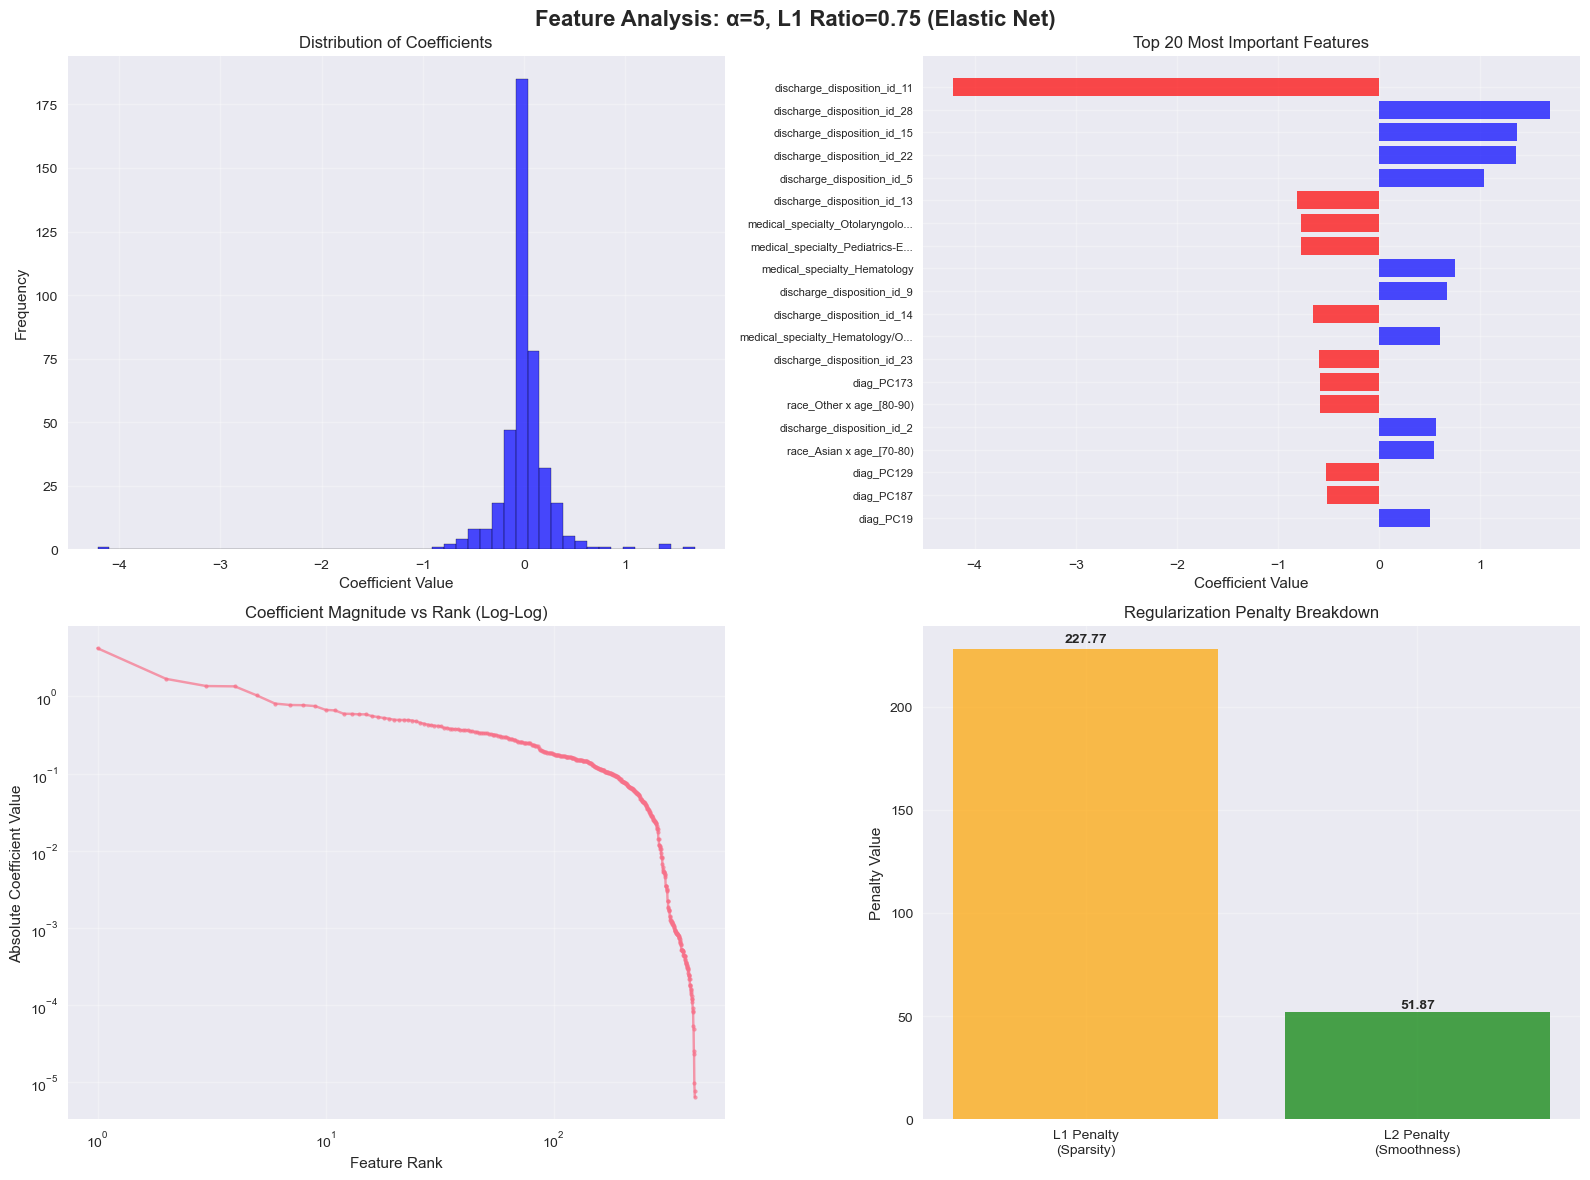

In [14]:
# FEATURE ANALYSIS VISUALIZATIONS
print("=== FEATURE ANALYSIS VISUALIZATIONS ===")

# Create feature analysis plots (removed absolute coefficient plot and pie plot)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Analysis: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. Coefficient Distribution
ax1 = axes[0, 0]
ax1.hist(feature_analysis_df['coefficient'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Coefficients')
ax1.grid(True, alpha=0.3)

# 2. Top 20 Features Bar Plot (flipped y-axis labels)
ax2 = axes[0, 1]
top_20 = feature_analysis_df.sort_values('abs_coefficient', ascending=False).head(20)
y_pos = np.arange(len(top_20))
colors = ['red' if x < 0 else 'blue' for x in top_20['coefficient']]
ax2.barh(y_pos, top_20['coefficient'], color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
# Flip y-axis labels to read top to bottom
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_20['feature_name']], fontsize=8)
ax2.invert_yaxis()  # This flips the y-axis so labels read top to bottom
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top 20 Most Important Features')
ax2.grid(True, alpha=0.3)

# 3. Coefficient Magnitude vs Rank
ax3 = axes[1, 0]
sorted_features = feature_analysis_df.sort_values('abs_coefficient', ascending=False)
ranks = np.arange(1, len(sorted_features) + 1)
ax3.loglog(ranks, sorted_features['abs_coefficient'], 'o-', markersize=3, alpha=0.7)
ax3.set_xlabel('Feature Rank')
ax3.set_ylabel('Absolute Coefficient Value')
ax3.set_title('Coefficient Magnitude vs Rank (Log-Log)')
ax3.grid(True, alpha=0.3)

# 4. Regularization Penalty Breakdown
ax4 = axes[1, 1]
l1_penalty = alpha * l1_ratio * np.sum(np.abs(model.coef_))
l2_penalty = alpha * (1 - l1_ratio) * np.sum(model.coef_ ** 2)
total_penalty = l1_penalty + l2_penalty

penalty_data = [l1_penalty, l2_penalty]
penalty_labels = ['L1 Penalty\n(Sparsity)', 'L2 Penalty\n(Smoothness)']
colors = ['orange', 'green']

bars = ax4.bar(penalty_labels, penalty_data, color=colors, alpha=0.7)
ax4.set_ylabel('Penalty Value')
ax4.set_title('Regularization Penalty Breakdown')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, penalty_data):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
print(f"\n📊 FEATURE ANALYSIS: PSEUDO R-SQUARED AND BINARY CLASSIFICATION METRICS")
print("=" * 70)

# Calculate pseudo R-squared and binary metrics for each feature individually
feature_pseudo_r2_scores = []
feature_auc_scores = []
feature_accuracy_scores = []
feature_log_loss_scores = []

print("🔍 Calculating individual feature pseudo R-squared and binary classification metrics...")

for i, feature_name in enumerate(feature_names):
    # Extract single feature
    X_single = train_X[:, i:i+1]  # Keep 2D shape
    
    # Fit logistic regression for this single feature
    lr = LogisticRegression(random_state=seed, max_iter=1000)
    lr.fit(X_single, train_y)
    
    # Predict probabilities on training set
    y_pred_proba = lr.predict_proba(X_single)[:, 1]
    y_pred = lr.predict(X_single)
    
    # Calculate pseudo R-squared (McFadden's)
    # Pseudo R² = 1 - (log-likelihood of model / log-likelihood of null model)
    log_likelihood_model = log_loss(train_y, y_pred_proba, normalize=False)
    # Null model: just predict the mean
    mean_prob = np.mean(train_y)
    null_probs = np.full_like(train_y, mean_prob, dtype=float)
    log_likelihood_null = log_loss(train_y, null_probs, normalize=False)
    
    pseudo_r2 = 1 - (log_likelihood_model / log_likelihood_null) if log_likelihood_null != 0 else 0
    feature_pseudo_r2_scores.append(pseudo_r2)
    
    # Calculate AUC
    try:
        auc = roc_auc_score(train_y, y_pred_proba)
        feature_auc_scores.append(auc)
    except:
        feature_auc_scores.append(0.5)  # Random classifier
    
    # Calculate accuracy
    accuracy = accuracy_score(train_y, y_pred)
    feature_accuracy_scores.append(accuracy)
    
    # Calculate log loss
    log_loss_score = log_loss(train_y, y_pred_proba)
    feature_log_loss_scores.append(log_loss_score)

# Add binary classification metrics to feature analysis dataframe
feature_analysis_df['pseudo_r2'] = feature_pseudo_r2_scores
feature_analysis_df['individual_auc'] = feature_auc_scores
feature_analysis_df['individual_accuracy'] = feature_accuracy_scores
feature_analysis_df['individual_log_loss'] = feature_log_loss_scores

# Sort by pseudo R-squared (descending)
pseudo_r2_sorted = feature_analysis_df.sort_values('pseudo_r2', ascending=False)

print(f"\n🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(pseudo_r2_sorted.head(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

print(f"\n🔻 BOTTOM 15 FEATURES BY PSEUDO R-SQUARED (LOWEST EXPLANATORY POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(pseudo_r2_sorted.tail(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

# Also show top features by individual AUC
auc_sorted = feature_analysis_df.sort_values('individual_auc', ascending=False)
print(f"\n🎯 TOP 15 FEATURES BY INDIVIDUAL AUC (HIGHEST DISCRIMINATIVE POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'AUC':<8} {'Pseudo R²':<10} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(auc_sorted.head(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['individual_auc']:6.4f}   {row['pseudo_r2']:8.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

# Calculate cumulative pseudo R-squared for top features
print(f"\n📈 CUMULATIVE PSEUDO R-SQUARED ANALYSIS:")
print(f"{'Top N Features':<15} {'Cumulative Pseudo R²':<20} {'% of Total Pseudo R²':<20}")
print("-" * 85)

total_pseudo_r2 = sum(feature_pseudo_r2_scores)
for n in [10, 20, 50, 100, 200, len(feature_names)]:
    if n <= len(pseudo_r2_sorted):
        top_n_pseudo_r2 = pseudo_r2_sorted.head(n)['pseudo_r2'].sum()
        percentage = (top_n_pseudo_r2 / total_pseudo_r2) * 100 if total_pseudo_r2 > 0 else 0
        avg_pseudo_r2 = top_n_pseudo_r2 / n if n > 0 else 0
        print(f"{n:<15}  {top_n_pseudo_r2:<20.4f}  {percentage:<20.1f}%")

# Correlation analysis between different metrics
pseudo_r2_coef_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], np.abs(feature_analysis_df['coefficient']))[0, 1]
pseudo_r2_auc_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], feature_analysis_df['individual_auc'])[0, 1]
auc_coef_corr = np.corrcoef(feature_analysis_df['individual_auc'], np.abs(feature_analysis_df['coefficient']))[0, 1]

print(f"\n🔗 CORRELATION ANALYSIS:")
print(f"Pseudo R² vs |Coefficient| correlation: {pseudo_r2_coef_corr:.4f}")
print(f"Pseudo R² vs Individual AUC correlation: {pseudo_r2_auc_corr:.4f}")
print(f"Individual AUC vs |Coefficient| correlation: {auc_coef_corr:.4f}")

# Summary statistics
print(f"\n📊 PSEUDO R-SQUARED SUMMARY STATISTICS:")
print(f"Mean Pseudo R²: {np.mean(feature_pseudo_r2_scores):.6f}")
print(f"Median Pseudo R²: {np.median(feature_pseudo_r2_scores):.6f}")
print(f"Max Pseudo R²: {np.max(feature_pseudo_r2_scores):.6f}")
print(f"Min Pseudo R²: {np.min(feature_pseudo_r2_scores):.6f}")
print(f"Std Pseudo R²: {np.std(feature_pseudo_r2_scores):.6f}")

print(f"\n📊 INDIVIDUAL AUC SUMMARY STATISTICS:")
print(f"Mean Individual AUC: {np.mean(feature_auc_scores):.6f}")
print(f"Median Individual AUC: {np.median(feature_auc_scores):.6f}")
print(f"Max Individual AUC: {np.max(feature_auc_scores):.6f}")
print(f"Min Individual AUC: {np.min(feature_auc_scores):.6f}")
print(f"Std Individual AUC: {np.std(feature_auc_scores):.6f}")

# Features with high pseudo R² but low coefficient magnitude (potential issues)
high_pseudo_r2_low_coef = feature_analysis_df[
    (feature_analysis_df['pseudo_r2'] > np.percentile(feature_pseudo_r2_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH PSEUDO R² BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_pseudo_r2_low_coef)} such features")

if len(high_pseudo_r2_low_coef) > 0:
    print(f"{'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'|Coeff|':<10}")
    print("-" * 85)
    for _, row in high_pseudo_r2_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['abs_coefficient']:8.4f}")

# Features with high individual AUC but low coefficient magnitude
high_auc_low_coef = feature_analysis_df[
    (feature_analysis_df['individual_auc'] > np.percentile(feature_auc_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH INDIVIDUAL AUC BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_auc_low_coef)} such features")

if len(high_auc_low_coef) > 0:
    print(f"{'Feature':<50} {'AUC':<8} {'Pseudo R²':<10} {'|Coeff|':<10}")
    print("-" * 85)
    for _, row in high_auc_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['individual_auc']:6.4f}   {row['pseudo_r2']:8.4f}   {row['abs_coefficient']:8.4f}")

# Save enhanced feature analysis
feature_analysis_df.to_csv('data/feature_analysis_with_binary_metrics_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Enhanced feature analysis with binary classification metrics saved to 'feature_analysis_with_binary_metrics_alpha5_l1ratio0.75.csv'")

print(f"\n💡 INTERPRETATION:")
print(f"   - Pseudo R² (McFadden's) measures goodness of fit for binary classification")
print(f"   - Individual AUC measures discriminative power of each feature alone")
print(f"   - High pseudo R² features have strong individual explanatory power")
print(f"   - High individual AUC features can distinguish between classes well")
print(f"   - Features with high metrics but low coefficients may indicate multicollinearity")
print(f"   - For binary outcomes, these metrics are more appropriate than regular R²")


📊 FEATURE ANALYSIS: PSEUDO R-SQUARED AND BINARY CLASSIFICATION METRICS
🔍 Calculating individual feature pseudo R-squared and binary classification metrics...

🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):
Rank Feature                                            Pseudo R²  AUC      Accuracy   Coefficient 
----------------------------------------------------------------------------------------------------
 1.  number_inpatient                                   0.0308   0.6075     0.8890       0.3381
 2.  discharge_disposition_id_22                        0.0060   0.5165     0.8889       1.3516
 3.  number_emergency                                   0.0059   0.5305     0.8889       0.0794
 4.  discharge_disposition_id_11                        0.0053   0.5091     0.8889      -4.2153
 5.  number_diagnoses                                   0.0040   0.5425     0.8889       0.0435
 6.  diag_PC0                                           0.0035   0.5432     0.8889      -0.0

In [16]:
print("=== ORIGINAL FEATURE ANALYSIS ===")

# Add original feature information to the feature analysis dataframe
feature_analysis_df['original_feature'] = feature_analysis_df['feature_name'].map(reverse_map)

# Group by original feature and calculate statistics for both positive and negative coefficients
original_feature_analysis = []

for original_feature in feature_analysis_df['original_feature'].unique():
    original_feature_data = feature_analysis_df[feature_analysis_df['original_feature'] == original_feature]
    
    # Separate positive and negative coefficients
    positive_coefs = original_feature_data[original_feature_data['coefficient'] > 0]['coefficient']
    negative_coefs = original_feature_data[original_feature_data['coefficient'] < 0]['coefficient']
    
    # Calculate statistics
    mean_abs_coef = original_feature_data['abs_coefficient'].mean()
    
    # Positive coefficient statistics
    if len(positive_coefs) > 0:
        mean_positive_coef = positive_coefs.mean()
        max_positive_coef = positive_coefs.max()
    else:
        mean_positive_coef = None
        max_positive_coef = None
    
    # Negative coefficient statistics
    if len(negative_coefs) > 0:
        mean_negative_coef = negative_coefs.mean()
        max_negative_coef = negative_coefs.min()  # Most negative (smallest value)
    else:
        mean_negative_coef = None
        max_negative_coef = None
    
    original_feature_analysis.append({
        'original_feature': original_feature,
        'mean_abs_coef': mean_abs_coef,
        'mean_positive_coef': mean_positive_coef,
        'max_positive_coef': max_positive_coef,
        'mean_negative_coef': mean_negative_coef,
        'max_negative_coef': max_negative_coef,
        'total_features': len(original_feature_data),
        'positive_features': len(positive_coefs),
        'negative_features': len(negative_coefs)
    })

# Convert to DataFrame and sort by mean absolute coefficient
original_feature_analysis_df = pd.DataFrame(original_feature_analysis)
original_feature_analysis_df = original_feature_analysis_df.sort_values('mean_abs_coef', ascending=False)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"Total original features: {len(original_feature_analysis_df)}")
print(f"Original features with both positive and negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] > 0)])}")
print(f"Original features with only positive features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] == 0)])}")
print(f"Original features with only negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] == 0) & (original_feature_analysis_df['negative_features'] > 0)])}")

print(f"\n🏆 RANKED ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:")
print(f"{'Rank':<4} {'Original Feature':<35} {'Max Pos':<10} {'Mean Pos':<10} {'Mean Neg':<10} {'Max Neg':<10} {'Features':<8}")
print("-" * 95)
for i, row in original_feature_analysis_df.iterrows():
    print(f"{i+1:2d}.   {row['original_feature']:33s}   {row['max_positive_coef']:8.4f}   {row['mean_positive_coef']:8.4f}"
          f"{row['mean_negative_coef']:8.4f}   {row['max_negative_coef']:8.4f}   {int(row['total_features']):6d}")

# Summary statistics
print(f"\n📈 COMBINED COEFFICIENT STATISTICS:")
print(f"Total features: {len(feature_analysis_df)}")
print(f"Original features with mixed signs: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] > 0)])}")
print(f"Average mean absolute coefficient: {original_feature_analysis_df['mean_abs_coef'].mean():.4f}")
print(f"Highest mean absolute coefficient: {original_feature_analysis_df['mean_abs_coef'].max():.4f}")

# Save combined analysis
original_feature_analysis_df.to_csv('data/original_feature_analysis_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Combined original feature analysis completed and saved to 'original_feature_analysis_alpha5_l1ratio0.75.csv'")


=== ORIGINAL FEATURE ANALYSIS ===

📊 ANALYSIS SUMMARY:
Total original features: 30
Original features with both positive and negative features: 11
Original features with only positive features: 10
Original features with only negative features: 9

🏆 RANKED ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:
Rank Original Feature                    Max Pos    Mean Pos   Mean Neg   Max Neg    Features
-----------------------------------------------------------------------------------------------
10.   discharge_disposition_id              1.6892     0.5148 -0.7035    -4.2153       25
 7.   number_inpatient                      0.3381     0.3381     nan        nan        1
18.   race x gender                         0.3668     0.2221 -0.1463    -0.1463        4
15.   race                                     nan        nan -0.1331    -0.2970        4
20.   gender x age                          0.1167     0.0666 -0.2582    -0.4750        9
30.   diag                                  0.4991     0.